In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Download historical data for Apple
data = yf.download('AAPL', start='2020-01-01', end='2025-09-01', interval='1d', auto_adjust=True)

data.head(5)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538528,72.598907,71.292319,71.545905,135480400
2020-01-03,71.833290,72.594055,71.608685,71.765667,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065140,72.671333,71.845362,72.415330,108872000
2020-01-08,73.224403,73.526295,71.768079,71.768079,132079200


In [29]:
# Example time series data
close = data['Close'] # Using closing prices

# Make sure the index is a proper datetime index
close.index = pd.to_datetime(close.index)

# Resample to monthly data (optional for smoother seasonality)
monthly_close = close.resample('ME').mean()


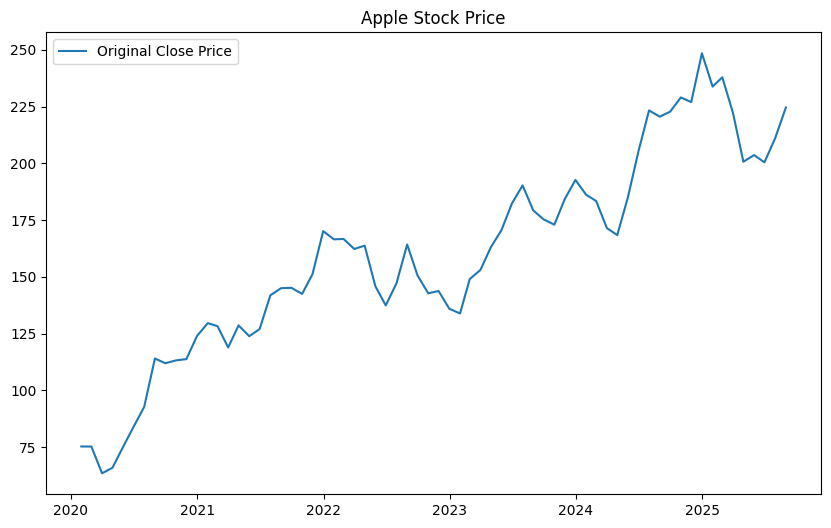

In [31]:
# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(monthly_close, label='Original Close Price')
plt.title('Apple Stock Price')
plt.legend()
plt.show()

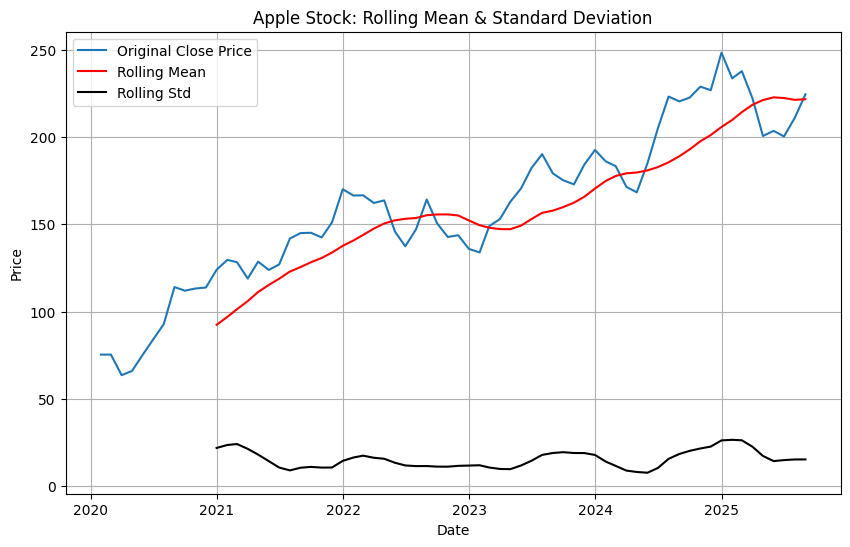

In [30]:
# Check for Stationarity: Using Rolling Mean and Standard Deviation

# Calculate rolling statistics
rolling_mean = monthly_close.rolling(window=12).mean()
rolling_std = monthly_close.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(10,6))
plt.plot(monthly_close, label='Original Close Price')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend(loc='best')
plt.title('Apple Stock: Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Rolling Statistics Analysis of Apple Stock Prices (2020–2025)

The chart above visualizes the **rolling mean** and **rolling standard deviation** for Apple stock prices over a five-year period:

1. **Blue Line (Original Close Price):**  
   The actual daily (or periodic) closing stock prices. We can see a clear upward trend, with prices rising significantly from around **$70 in 2020** to over **$230 in 2025**.

2. **Red Line (Rolling Mean):**  
   The moving average (smoothed trend) over a chosen window (e.g., 12 months).  
   - The rolling mean line clearly trends upward, confirming the series is **not stationary**.  
   - The gradual increase shows strong long-term growth in Apple’s stock price.

3. **Black Line (Rolling Std):**  
   The rolling standard deviation shows how volatile the stock price is over time.  
   - The variation fluctuates but does not remain constant, further confirming **non-stationarity**.  
   - Periods of higher volatility appear around 2024–2025.

---

#### 🔍 Key Insights:
- The stock price is **clearly non-stationary**: Both mean and variance change over time.  
- This aligns with typical stock price behavior, which often trends upward and has periods of volatility.  
- Before modeling (e.g., with ARIMA), the series would require **differencing** or **transformations** (like log scaling) to make it stationary.



# Time Series Decomposition

In [21]:
# To Decompose the time series, we need a datetime index

# Make sure the index is a proper datetime index
close.index = pd.to_datetime(close.index)

# Resample to monthly data (optional for smoother seasonality)
monthly_close = close.resample('ME').mean()

# Decompose the time series
decomposition = seasonal_decompose(monthly_close, model='additive', period=12)

In [24]:
# Plot the decomposition
# plt.rcParams.update({'figure.figsize': (12, 8)})
# decomposition.plot()
# plt.suptitle('Apple Stock Price Decomposition (Additive Model)', fontsize=16)
# plt.show()

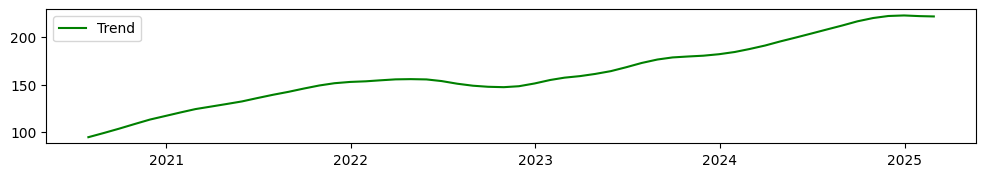

In [25]:
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')

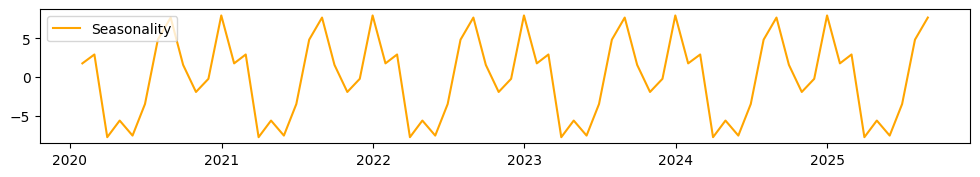

In [26]:
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend(loc='upper left')

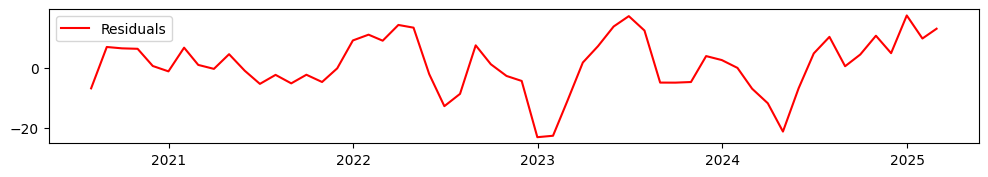

In [27]:
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

In [32]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_test = adfuller(monthly_close.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Check critical values
for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -0.9027192179802646
p-value: 0.7870756211927088
Critical Value (1%): -3.548493559596539
Critical Value (5%): -2.912836594776334
Critical Value (10%): -2.594129155766944


## Converting Non Statinary to Stationary Time Series

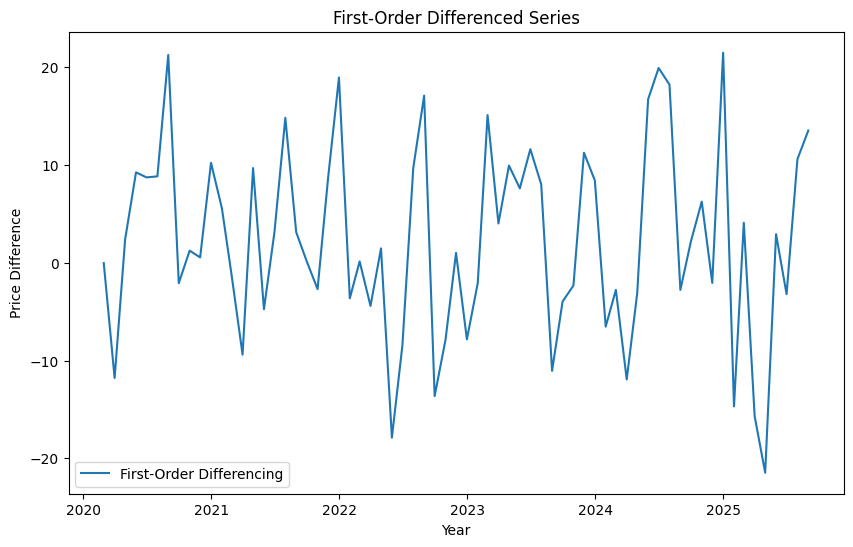

In [35]:
# Apply first-order differencing
data_diff = monthly_close.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff, label='First-Order Differencing')
plt.title('First-Order Differenced Series')
plt.xlabel('Year')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [34]:
# Perform ADF test on differenced data
adf_test_diff = adfuller(data_diff)
print(f'ADF Statistic (Differenced): {adf_test_diff[0]}')
print(f'p-value (Differenced): {adf_test_diff[1]}')


ADF Statistic (Differenced): -4.270828795145421
p-value (Differenced): 0.0004988177101325119


### Stationarity Check with Augmented Dickey-Fuller (ADF) Test

We tested **Apple Stock Prices (2020–2025)** for stationarity using the **ADF test** before and after applying first-order differencing.

---

#### ADF Test (Original Series):
- **ADF Statistic:** `-0.9027`  
- **p-value:** `0.7871`  
- **Critical Values:**  
  - 1%: `-3.5485`  
  - 5%: `-2.9128`  
  - 10%: `-2.5941`  

**Interpretation:**  
- The ADF statistic is **higher than all critical values**, and the p-value (`0.7871`) is **far above 0.05**.  
- We **fail to reject the null hypothesis** → The original stock price series is **non-stationary**.  
- This aligns with the visible upward trend and changing variance.

---

#### ADF Test (After First-Order Differencing):
- **ADF Statistic:** `-4.2708`  
- **p-value:** `0.0005`  

**Interpretation:**  
- The ADF statistic is **lower than all critical values**, and the p-value is **well below 0.05**.  
- We **reject the null hypothesis** → The differenced series is **stationary**.  
- Differencing successfully removed the trend, stabilizing the mean and variance.

---

#### Key Takeaways:
1. Stock price levels are **non-stationary**, making direct time-series modeling inaccurate.  
2. **First-order differencing** is effective for achieving stationarity, a requirement for ARIMA and similar models.  


